In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsOneClassifier
import pandas as pd
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

---
## $\textcolor{green}{\text{Softmax function}}$

When we did a two class classification with logistic regression, we used a sigmoid function as our activation function to produce probabilities for each class. However, sigmoid will not work well if we have multiple classes. Sigmoid produceS probabilities of individual classes and it assumes thst the input can belong to multiple classes. Because of that, the total usually doesn't add up to one. So instead, we can use a generalized version of this function called Softmax. Suppose we have $K$ classes and we get logit vector $\bf{z}$ (output of some linear function), then Softmax $S(\bf{z})$ is a probability vector whose j-th entry is

$$\textcolor{blue}{S({\bf z})_j=\frac{e^{z_j}}{\sum_i^K e^{z_i}}}$$

The higher the value of $z_j$ is, the higher the corresponding probability $S({\bf z})_j$ is.

<div class="alert alert-block alert-info"><b>Note:</b>
Here is a link to play around in Desmos: <a href="https://www.desmos.com/calculator/drqqhtb037">https://www.desmos.com/calculator/drqqhtb037</a> . Here you can change a,b,c,d values on the left and the bottom graph shows you corresponding probabilities and their total.</div>

So, to classify input ${\bf z}$, we can apply softmax followed by $argmax$ function which is a function that picks the class with highest probability. Let's look at the example with 4 classes.

#### $\textcolor{red}{\text{Example}}$

In [6]:
z=np.array([0.3, -3.4, 1.6, 0])

def Softmax(z):
    return np.exp(z)/np.exp(z).sum()

Softmax(z)

array([0.18399811, 0.00454908, 0.67514365, 0.13630915])

In [7]:
np.argmax(Softmax(z))

2

As you can see, we get the class 2 (1.6 is the largest number). 

The result is always a class whose value is largest, so it might be tempting to forget softmax and apply argmax right away. However, gradients of argmax are zero, so it will not work with backpropagation. In other words, argmax is a good function as a threshold function, but not as an activation function.

---

For binary classification, weights for our linear model depend only on the number features. However, in the multinomial case, they depend on the number of features and the number of classes. To see this, consider what we are trying to compute. We want to get the probability of getting one of the classes given some features $x^{(i)}$  (i.e. $P(y=k \:|\: x^{(i)})$). In other words we want a vector:

$$\begin{bmatrix}P(y=1 \:|\: {\bf x}^{(i)}) \\ P(y=2 \:|\: {\bf x}^{(i)}\\ \cdots \\ P(y=c \:|\: {\bf x}^{(i)} \end{bmatrix}$$

For each of those probabilities we will use linear classifier as in the logistic regression, but each of those probabilities may have different weights and biases:

$$\begin{bmatrix}{\bf x}^{(i)} \cdot {\bf w}_1 +b_1\\ {\bf x}^{(i)} \cdot {\bf w}_2+b_2\\ \cdots \\ {\bf x}^{(i)} \cdot {\bf w}_c +b_c \end{bmatrix} = W {\bf x}^{(i)} +{\bf b}$$

So, we no longer have a weight vector, but a $f \times c$ weight matrix $W$. Finally, the value we get ${\bf z}^{(i)}=W {\bf x}^{(i)} +{\bf b}$ is called logit and it is not a probability vector yet, and so we use Softmax function to make it into probability vector.


Our forward pass then will compute $\textcolor{blue}{{\bf a}^{(i)}=S({\bf z}^{(i)})=S(W {\bf x}^{(i)} +{\bf b})}$ or if we have usual array of data $X$, we can rewrite this as $S(XW^T +{\bf b})$ abusing notation.

---

## $\textcolor{green}{\text{Derivative of Softmax function}}$

It would be helpful in the future to know various derivatives of Softmax function. Suppose $\bf{z}=\begin{bmatrix}z_1 \\ z_2 \\z_3 \end{bmatrix}$, then $S({\bf z})=\begin{bmatrix}S({\bf z})_1 \\ S({\bf z})_2 \\S({\bf z})_3 \end{bmatrix}=\begin{bmatrix}a_1 \\ a_2 \\a_3 \end{bmatrix}$, where $$S({\bf z})_j=a_j=\frac{e^{z_j}}{e^{z_1}+e^{z_2}+e^{z_3}}$$

Let's find derivative of $a_1$ with respect to $z_1$:
$$\begin{equation}
\begin{aligned}
\frac{\partial a_1}{\partial z_1} & =\frac{e^{z_1}(e^{z_1}+e^{z_2}+e^{z_3})-e^{z_1}e^{z_1}}{(e^{z_1}+e^{z_2}+e^{z_3})^2}=\frac{ e^{z_1} [(e^{z_1}+e^{z_2}+e^{z_3})-e^{z_1}]}{(e^{z_1}+e^{z_2}+e^{z_3})^2} \\
& = \frac{ e^{z_1}}{e^{z_1}+e^{z_2}+e^{z_3}}\frac{ (e^{z_1}+e^{z_2}+e^{z_3})-e^{z_1}}{e^{z_1}+e^{z_2}+e^{z_3}} \\
& =\frac{ e^{z_1}}{e^{z_1}+e^{z_2}+e^{z_3}}\left(1-\frac{ e^{z_1}}{e^{z_1}+e^{z_2}+e^{z_3}}\right) = a_1(1-a_1)
\end{aligned}
\end{equation}$$

Next, let's find derivative of $a_1$ with respect to $z_2$:

$$\begin{equation}
\begin{aligned}
\frac{\partial a_1}{\partial z_2} & =\frac{0(e^{z_1}+e^{z_2}+e^{z_3})-e^{z_1}e^{z_2}}{(e^{z_1}+e^{z_2}+e^{z_3})^2}=\frac{ -e^{z_1}e^{z_2}}{(e^{z_1}+e^{z_2}+e^{z_3})^2} \\
& = \frac{ -e^{z_1}}{e^{z_1}+e^{z_2}+e^{z_3}}\frac{ e^{z_2}}{e^{z_1}+e^{z_2}+e^{z_3}} = -a_1 a_2
\end{aligned}
\end{equation}$$

With these we know all possible derivatives. We basically have only two cases: where indecies match and where they don't match.

---

## $\textcolor{green}{\text{Cross Entropy Loss Function}}$

We also need to generalize loss function. For binary classification logistic regression, we used negative log likelihood loss function (also known as binary cross entropy function):
$$LogL=-\frac{1}{N}\sum_{i=1}^{N}y^{(i)} \ln(\hat{y}^{(i)})+(1-y^{(i)})\ln(1-\hat{y}^{(i)})$$

This assumes binary classification since we use probabilities $y^{(i)}$ and $1-y^{(i)}$. We can slightly rewrite this by considering ${\bf y}$ and ${\bf a}$ as vectors of true class probabilities and predicted class probabilities:

$$LogL=- \frac{1}{N}\sum_{i=1}^{N}\left(y^{(i)}_1 \cdot \ln(a^{(i)}_1)+ y_2^{(i)} \cdot \ln(a^{(i)}_2) \right)= -\frac{1}{N} \sum_{i=1}^{N}\sum_{c=1}^2 y^{(i)}_c \cdot \ln(a^{(i)}_c)=-\frac{1}{N} \sum_{i=1}^N {\bf y}^{(i)} \cdot \ln({\bf a}^{(i)}) $$

Note that ${\bf y}^{(i)}$ is just a vector full of zeros and single 1. 
We generalize this to Cross Entropy Loss Function for $K$ classes:

$$L=-\frac{1}{N} \sum_{i=1}^N  {\bf y}^{(i)} \cdot \ln({\bf a}^{(i)})$$

<div class="alert alert-block alert-info"><b>Note:</b>
We using  ${\bf a}^{(i)}$ instead of $\hat{\bf y}^{(i)}$  as we would like to use $\hat{\bf y}^{(i)}$ as the final predictions (i.e. argmax of ${\bf a}^{(i)}$). </div>

The gradient (or more precisely Jacobian, since W is a matrix) is a bit tricker to compute. Consider the following diagram showing 3 features and 2 classes:

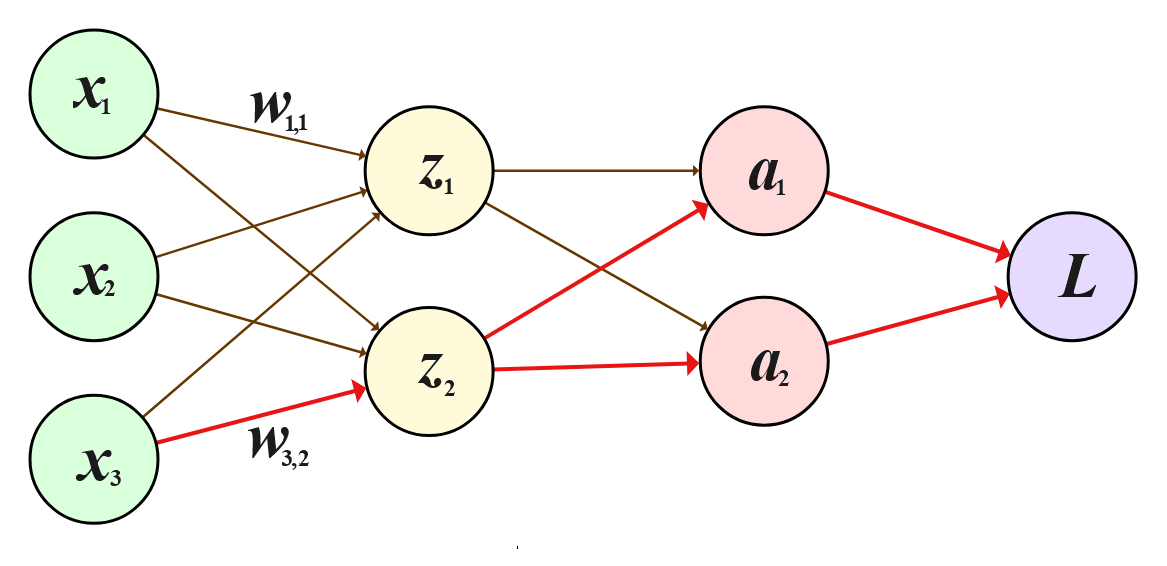

In the example above, let's pick one of the entries of the Jacobian and compute it:
$$\begin{equation}
\begin{aligned}
\frac{\partial L}{\partial w_{3,2}} & = \frac{\partial L}{\partial a_1}\cdot\frac{\partial a_1}{\partial z_2}\cdot\frac{\partial z_2}{\partial w_{2,3}} + \frac{\partial L}{\partial a_2}\cdot\frac{\partial a_2}{\partial z_2}\cdot\frac{\partial z_2}{\partial w_{2,3}} \\
& = -\frac{y_1}{a_1} \cdot (-a_1a_2) \cdot x_3 + -\frac{y_2}{a_2}\cdot (a_2(1-a_2)) \cdot x_3 \\
& = - (y_2 - a_2 )x_3
\end{aligned}
\end{equation}$$

Note that $y_1+y_2=1$.

Putting back the $1/N$ and rewriting it as matrix multiplication we get the full Jacobian:

$$ \nabla_W L = -\left(\frac{1}{N} (Y-A)^TX\right)^T$$

Note that $Y$ and $A$ are $n \times c$ matrices, each row of which is a target probability vector for each data point.

And for the bias term it is quite similar:
$$\frac{\partial L}{\partial {\bf b}}=-\frac{1}{N}\sum_{i=1}^{N}(y-a)$$

Compare this to what we had in the binary case. You should see it is quite similar, though calculations here are much harder. 

<div class="alert alert-block alert-info"><b>Note:</b>
For more details on calculations, you can check the following video: <a href="https://www.youtube.com/watch?v=aeM-fmcdkXU">https://www.youtube.com/watch?v=aeM-fmcdkXU</a> 
</div>


---

### $\textcolor{red}{\text{Examples}}$
Let's try to apply this on the Iris dataset that has three classes.

I will also use plotting function from previuos class. We will then upload the Iris set, scale it and look at pairwise plots.

In [2]:

# Helper function to plot a decision boundary.
def plot_decision_boundary(X, y, model, resolution=0.02):
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    markers = ('s', 'x', 'o', '^', 'v')      
    
    # Set min and max values and give it some padding
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution))
    # Predict the function value for the whole grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


    for idx, cl in enumerate(np.unique(y)): 
        plt.scatter(X[y==cl, 0], X[y==cl, 1],  color=cmap(idx),edgecolors='k',marker=markers[idx],label=cl)



In [3]:
dataset=datasets.load_iris()
X = dataset.data
y = dataset.target

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
sc=StandardScaler()

X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

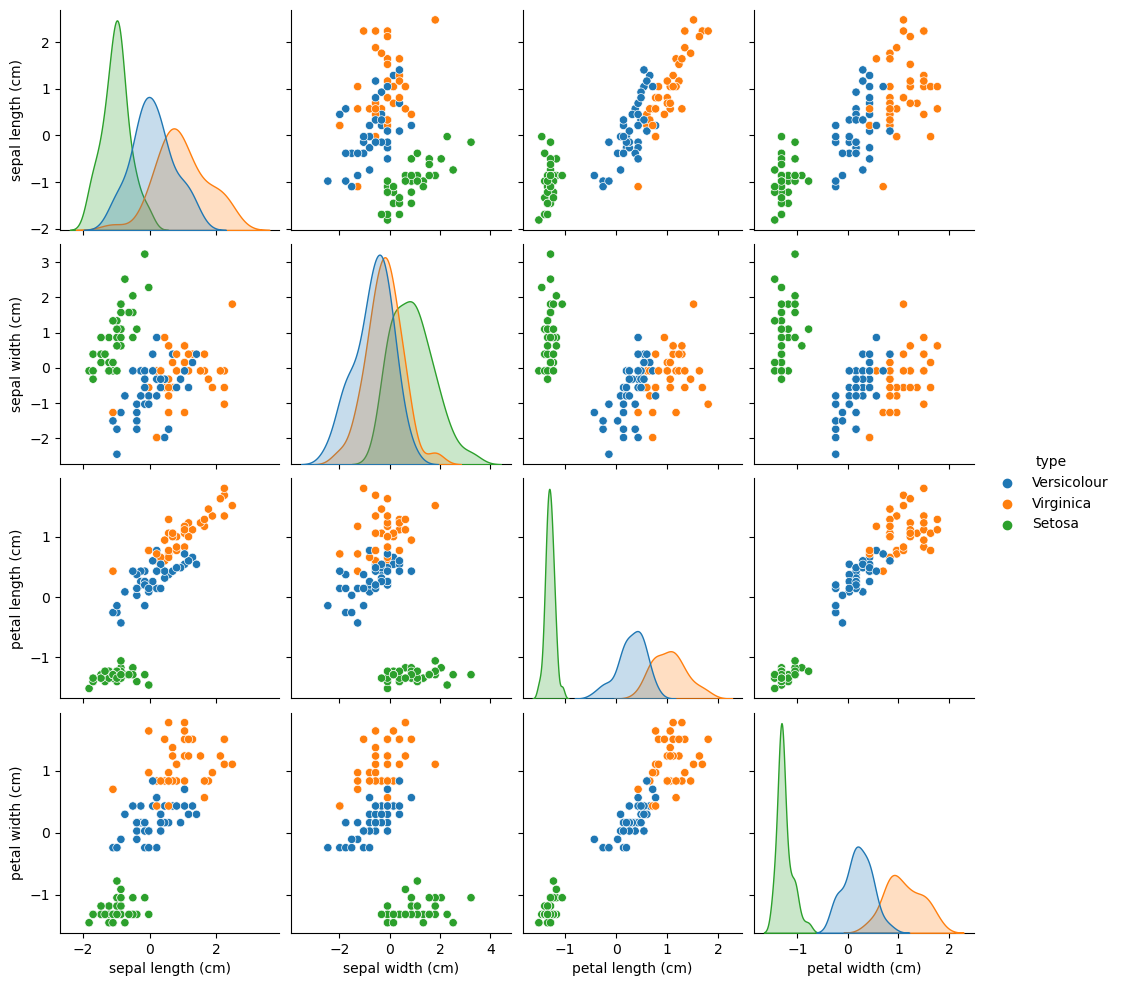

In [5]:
df = pd.DataFrame(data=X_train, columns=dataset.feature_names)
df['type'] = pd.DataFrame(data=y_train)
label_dict = {0:'Setosa',1:'Versicolour', 2:'Virginica'}
df['type']=df.type.map(label_dict)
sns.pairplot(df, hue="type")
plt.show()

For now we will consider only petal length and petal width. Let's create and apply multinomial logistic regression to this set.

In [6]:
X2_train=X_train[:,[2,3]]
y2_train=y_train
X2_test=X_test[:,[2,3]]
y2_test=y_test

In [7]:
n_samples, n_features = X2_train.shape

lr=0.01
n_epoch=5000

In [8]:
class MultiClassLogisticRegression:
    
    def __init__(self, n_epoch = 10000, lr=0.01, thres=0.001):
        self.n_epoch = n_epoch
        self.thres = thres
        self.lr=lr
        self.weights=None
        self.bias=None

    def __onehot__(self, y):
        classes = np.unique(y)
        y = np.eye(len(classes))[y]
        return y

    def __softmax__(self, z):
        return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)

    def __cross_entropy__(self, a, y):
        return -1 * np.mean(y * np.log(a))

    def __forward__(self, X):
        z=np.dot(X, self.weights)+self.bias
        a=self.__softmax__(z)
        return z,a
    
    def fit(self, X, y): 
        n_class=len(np.unique(y))
        n_samples, n_feat = X.shape
        self.weights= np.zeros(( n_feat, n_class))
        self.bias=np.zeros(n_class)

        for i in range(self.n_epoch):
            y_hot=self.__onehot__(y)

            z, a = self.__forward__(X)

            dw=-np.dot((y_hot-a).T, X).T/X.shape[0]
            db=-(y_hot-a).mean(axis=0)
            
            if np.abs(dw).max() < self.thres: break
                
            self.weights = self.weights - self.lr*dw
            self.bias = self.bias - self.lr*db
            
            loss=np.mean(self.__cross_entropy__(a,y_hot))

            if (i+1)%1000 == 0:
                print(f'Epoch = {(i+1)}:, Loss: {loss:.03f}')

    
    def predict(self, X):

        _, a=self.__forward__(X)
        return np.argmax(a, axis=1)
      
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [9]:
model= MultiClassLogisticRegression(n_epoch,lr)

In [10]:
model.fit(X2_train, y2_train)

Epoch = 1000:, Loss: 0.127
Epoch = 2000:, Loss: 0.095
Epoch = 3000:, Loss: 0.079
Epoch = 4000:, Loss: 0.069
Epoch = 5000:, Loss: 0.062


In [11]:
print('Weights: ' ,model.weights)
print('bias: ',model.bias)

Weights:  [[-2.26805506  0.34671747  1.9213376 ]
 [-2.04955734 -0.34997902  2.39953636]]
bias:  [-0.63220488  1.67146913 -1.03926425]


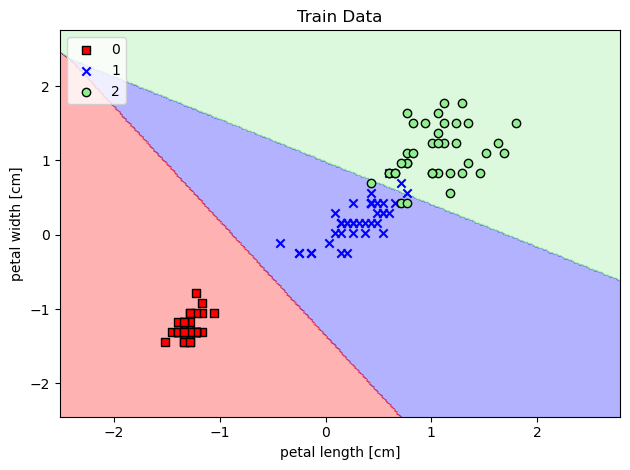

Accuracy =  0.95


In [12]:
plot_decision_boundary(X2_train, y2_train, model)
plt.legend(loc='upper left')
plt.title("Train Data")
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_train, y2_train))

In [13]:
y_train_pred=model.predict(X2_train)
confusion_matrix(y2_train,y_train_pred)

array([[40,  0,  0],
       [ 0, 39,  3],
       [ 0,  3, 35]], dtype=int64)

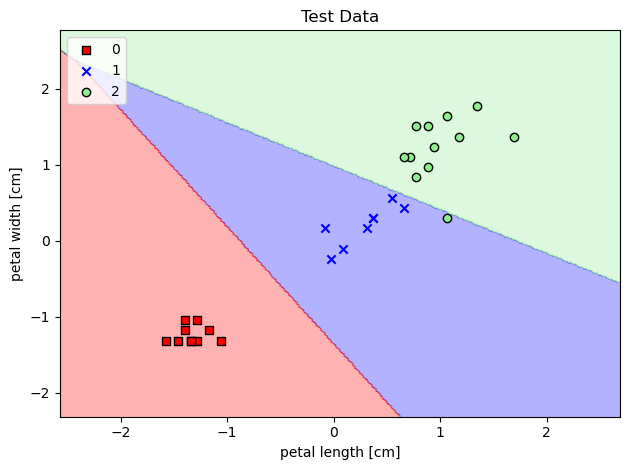

Accuracy =  0.9666666666666667


In [14]:
plot_decision_boundary(X2_test, y2_test, model)
plt.title("Test Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_test, y2_test))

In [15]:
y_test_pred=model.predict(X2_test)
confusion_matrix(y2_test,y_test_pred)

array([[10,  0,  0],
       [ 0,  8,  0],
       [ 0,  1, 11]], dtype=int64)

---

#### $\textcolor{red}{\text{Example using SKlearn}}$

Here is a fast way using Sklearn:

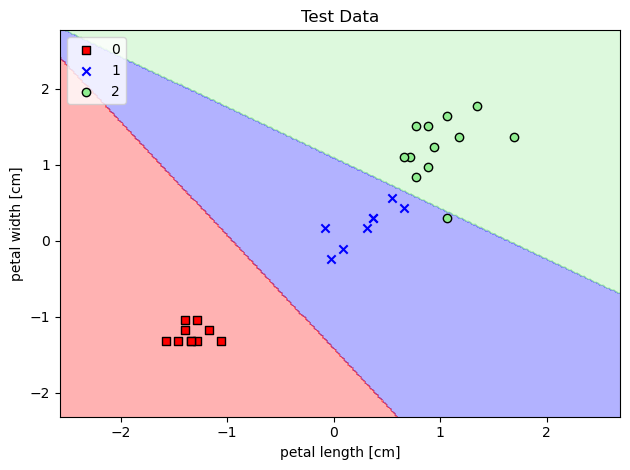

Accuracy =  0.9666666666666667


In [16]:
model = LogisticRegression( solver='sag',multi_class='multinomial', max_iter=n_epoch)
model.fit(X2_train, y2_train)
plot_decision_boundary(X2_test,y2_test,model)
plt.title("Test Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_test, y2_test))

As you can see, it differs a bit. SKlearn's Logistic Regression doesn't support GD or SGD. In the above example we used `solver='sag'`, which stands for "Stochastic Average Gradient". There are many other optimizers that can be used.

---

## $\textcolor{green}{\text{OVR and OVO}}$

We can also perform logistic regression using different approaches. We just did a multinomial approach with gradient descent. Another common way is to use OVR (one versus the rest). In this case, we go through loop each time we do a binary logistic regression using one class and the rest as another class. So, in essence we have multiple binary models. Given a data point we look at the probabilties in each model of data point belonging to a specific class. Here what it will look like using SKlearn:

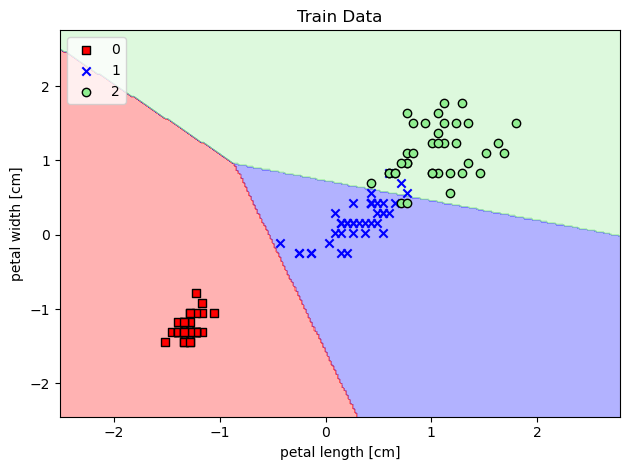

Accuracy =  0.9583333333333334


In [17]:
model = LogisticRegression( penalty='l2', solver='sag',multi_class='ovr', max_iter=n_epoch)
model.fit(X2_train, y2_train)
plot_decision_boundary(X2_train,y2_train,model)
plt.title("Train Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_train, y2_train))

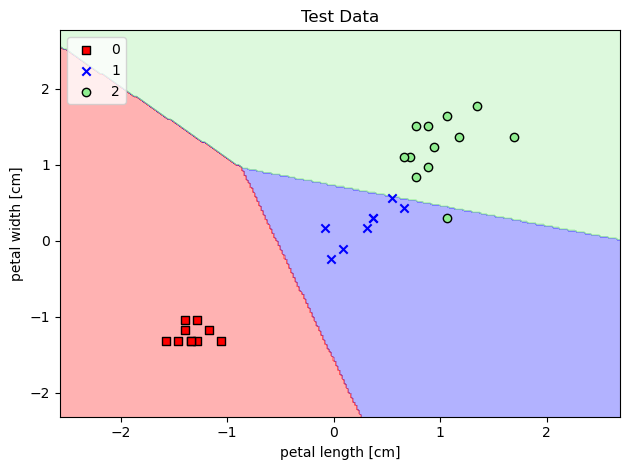

Accuracy =  0.9666666666666667


In [18]:
plot_decision_boundary(X2_test,y2_test,model)
plt.title("Test Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_test, y2_test))

There is also OVO (one vs one). In this case we would do multiple binary logistic regression models each time comparing only two classes (e.g. green vs red, blue vs red, green vs blue).

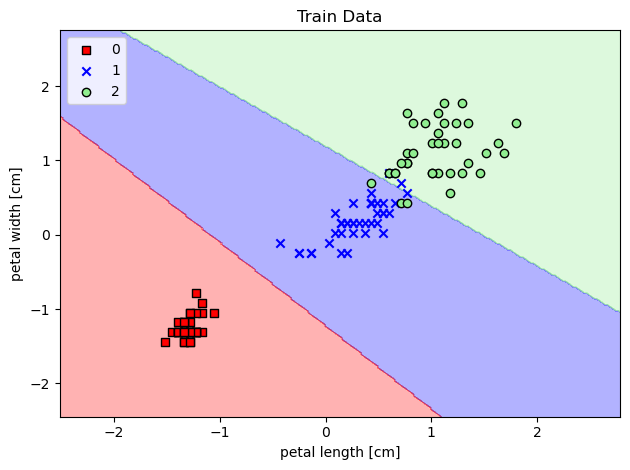

Accuracy =  0.9583333333333334


In [19]:
model = OneVsOneClassifier( LogisticRegression())
model.fit(X2_train, y2_train)
plot_decision_boundary(X2_train,y2_train,model)
plt.title("Train Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_train, y2_train))

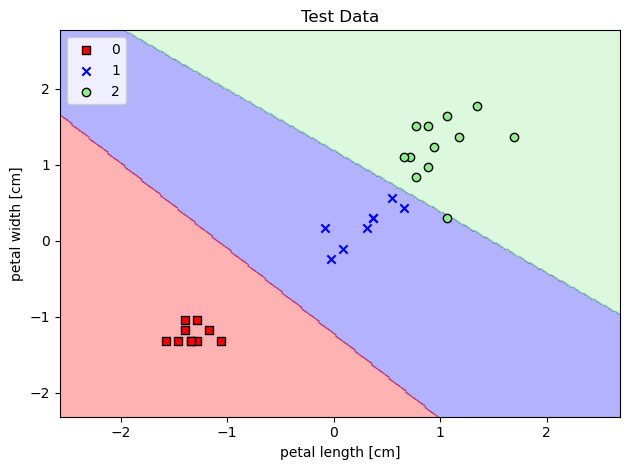

Accuracy =  0.9666666666666667


In [20]:
plot_decision_boundary(X2_test,y2_test,model)
plt.title("Test Data")
plt.legend(loc='upper left')
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.tight_layout()
plt.show()
print("Accuracy = ", model.score(X2_test, y2_test))

---

#### $\textcolor{red}{\text{PyTorch Example}}$

In [21]:
X3_train=torch.tensor(X2_train, dtype=torch.float)
y3_train=torch.tensor(y2_train, dtype=torch.int)
X3_test=torch.tensor(X2_test, dtype=torch.float)
y3_test=torch.tensor(y2_test, dtype=torch.int)

n_samples, n_features = X3_train.shape


lr=0.01
n_epoch=5000
thres=0.001

In [22]:

class MultiClassLogisticRegression(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(MultiClassLogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)
        # initialize weights to zeros here,
        # since we used zero weights in the
        # manual approach
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        # Note: the trailing underscore
        # means "in-place operation" in the context
        # of PyTorch
        
    def forward(self, x):
        logits = self.linear(x)
        probas = nn.Softmax()(logits)
        return logits, probas

model2 = MultiClassLogisticRegression(num_features=n_features, num_classes=3)
optimizer = torch.optim.SGD(model2.parameters(), lr=lr)
lossfunc=nn.CrossEntropyLoss()

In [23]:

def comp_accuracy(true_labels, pred_labels):
    accuracy = torch.sum(true_labels.view(-1).float() == 
                         pred_labels.float()).item() / true_labels.size(0)
    return accuracy



train_loss=[]
test_loss=[]
Time=n_epoch

for epoch in range(n_epoch):
    
    logits, probas = model2(X3_train)
    loss = lossfunc(logits, y3_train.long())    #nn.CrossEntropyLoss applies softmax already
    optimizer.zero_grad()
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()
    

    model2.eval()    
    with torch.inference_mode(): 
    
        logits, probas = model2(X3_train)
        acc = comp_accuracy(y3_train, torch.argmax(probas, dim=1))

        if (epoch+1)%500 ==0:
            print('Epoch: %03d' % (epoch + 1), end="")
            print(' | Train ACC: %.3f' % acc, end="")
            print(' | Cost: %.3f' % lossfunc(logits, y3_train.long()))
        y_test_pred,_=model2(X3_test)
        lost_test=lossfunc(y_test_pred, y3_test.long())
        test_loss.append(lost_test)
        
        if np.abs(model2.linear.weight.grad.max()) < thres: 
            Time=epoch+1
            break
        
print('\nModel parameters:')
print('  Weights: %s' % model2.linear.weight)
print('  Bias: %s' % model2.linear.bias)

Epoch: 500 | Train ACC: 0.833 | Cost: 0.481
Epoch: 1000 | Train ACC: 0.958 | Cost: 0.380
Epoch: 1500 | Train ACC: 0.958 | Cost: 0.323
Epoch: 2000 | Train ACC: 0.958 | Cost: 0.285
Epoch: 2500 | Train ACC: 0.950 | Cost: 0.258
Epoch: 3000 | Train ACC: 0.950 | Cost: 0.237
Epoch: 3500 | Train ACC: 0.950 | Cost: 0.220
Epoch: 4000 | Train ACC: 0.950 | Cost: 0.207
Epoch: 4500 | Train ACC: 0.950 | Cost: 0.196
Epoch: 5000 | Train ACC: 0.950 | Cost: 0.187

Model parameters:
  Weights: Parameter containing:
tensor([[-2.2681, -2.0496],
        [ 0.3467, -0.3500],
        [ 1.9213,  2.3995]], requires_grad=True)
  Bias: Parameter containing:
tensor([-0.6322,  1.6715, -1.0393], requires_grad=True)


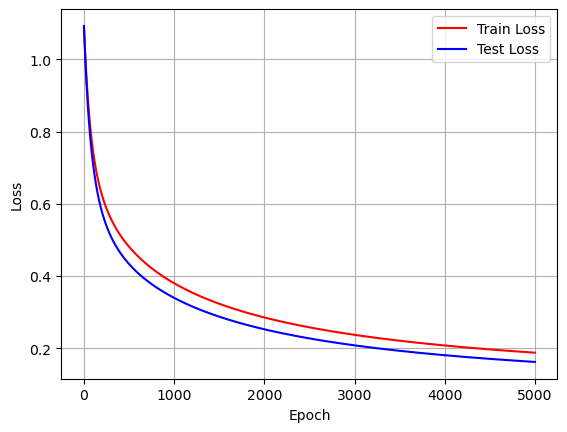

In [24]:
fig=plt.figure()
xv=np.arange(1,Time,1)
plt.plot(xv,train_loss[1:], 'r', label="Train Loss")
plt.plot(xv,test_loss[:-1], 'b', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [25]:
# This is the same helpful plot function modified so that it can be used with PyTorch

def plot_decision_boundary_torch(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    tensor = torch.tensor(np.array([xx1.ravel(), xx2.ravel()]).T).float()
    _, probas = classifier.forward(tensor)
    Z = np.argmax(probas.detach().numpy(), axis=1)

    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

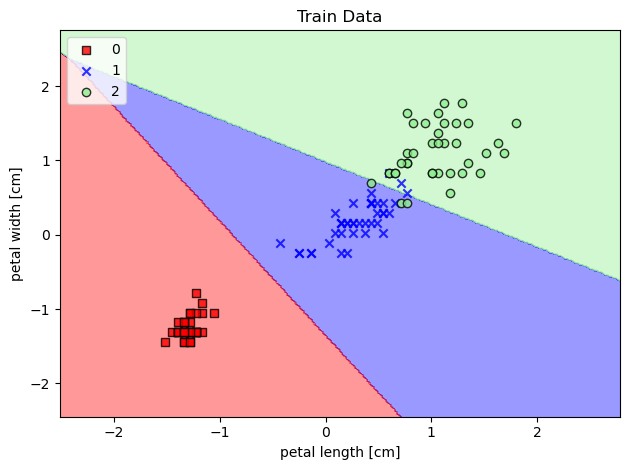

In [26]:
plot_decision_boundary_torch(X3_train, y3_train, classifier=model2)
plt.title("Train Data")
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


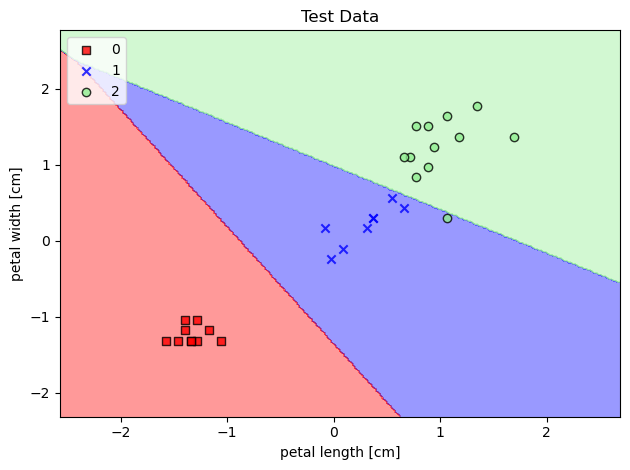

In [27]:
plot_decision_boundary_torch(X3_test, y3_test, classifier=model2)
plt.title("Test Data")
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()